# Smart Irrigation — Predicting Water Needed (ML Project)

**Goal:** Predict water requirement (L/m²) for crops using soil and weather features.

**Dataset:** `smart_irrigation_dataset_30000.csv` (synthetic)

**What this notebook contains:**

- Data loading and exploratory data analysis (EDA)
- Preprocessing (encoding + scaling)
- Training RandomForest and GradientBoosting models
- Model evaluation (RMSE, R²)
- Feature importance plots
- SHAP explainability (requires `shap` — install in the notebook environment)

---


In [1]:
# Setup: imports and config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

RANDOM_STATE = 42
DATA_PATH = "smart_irrigation_dataset_30000.csv"  # ensure this file is in the notebook folder
OUTPUT_DIR = "models_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print('Ready. Make sure the dataset file is available at', DATA_PATH)

Ready. Make sure the dataset file is available at smart_irrigation_dataset_30000.csv


In [2]:
# Load dataset
df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (30000, 6)


,Soil_Moisture(%),Temperature(°C),Humidity(%),Rainfall(mm),Crop_Type,Water_Needed(L/m²)
0,28.727006,30.953614,71.908864,131.573874,Soybean,10.80
1,57.535715,26.482311,81.677131,136.075866,Soybean,0.00
2,46.599697,39.112463,52.422591,56.755848,Rice,51.88
3,39.932924,20.474461,40.242511,34.744608,Soybean,21.66
4,17.800932,29.696410,42.319260,28.749158,Soybean,43.59


## Exploratory Data Analysis (EDA)

We'll look at distributions, correlations, and per-crop summaries.

,count,mean,std,min,25%,50%,75%,max
Soil_Moisture(%),30000.0,34.978997,14.396155,10.000582,22.562611,35.013576,47.388406,59.996241
Temperature(°C),30000.0,27.489348,7.221900,15.000138,21.241013,27.499580,33.759253,39.999304
Humidity(%),30000.0,55.047972,20.190007,20.009018,37.474845,55.190449,72.674506,89.999443
Rainfall(mm),30000.0,74.874917,43.324383,0.004129,37.066243,75.125115,112.316423,149.996396
Water_Needed(L/m²),30000.0,28.192289,18.158103,0.000000,14.150000,26.950000,40.660000,95.020000



Crop counts:
Crop_Type
Soybean    7593
Wheat      7501
Rice       7491
Maize      7415
Name: count, dtype: int64


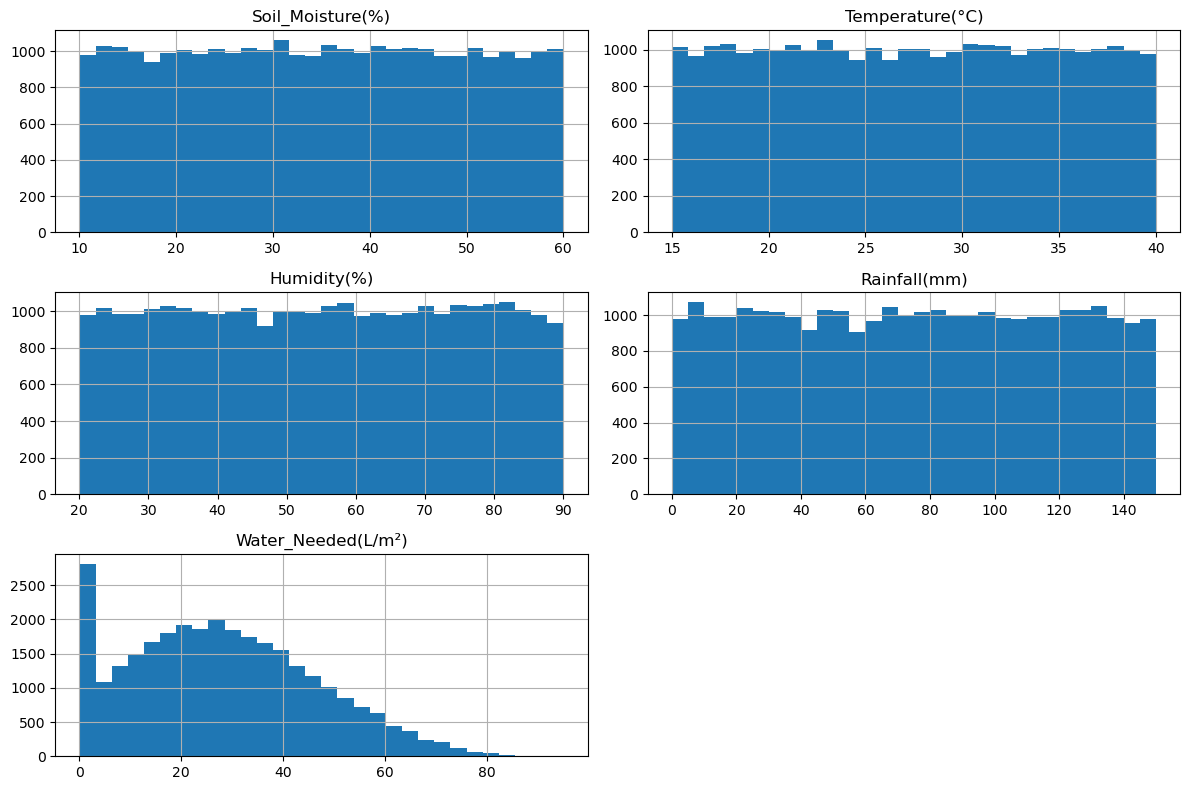

In [3]:
# Basic statistics and distributions
display(df.describe().T)

# Value counts for crop types
print('\nCrop counts:')
print(df['Crop_Type'].value_counts())

# Histograms for numeric features
num_cols = ['Soil_Moisture(%)','Temperature(°C)','Humidity(%)','Rainfall(mm)','Water_Needed(L/m²)']
df[num_cols].hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

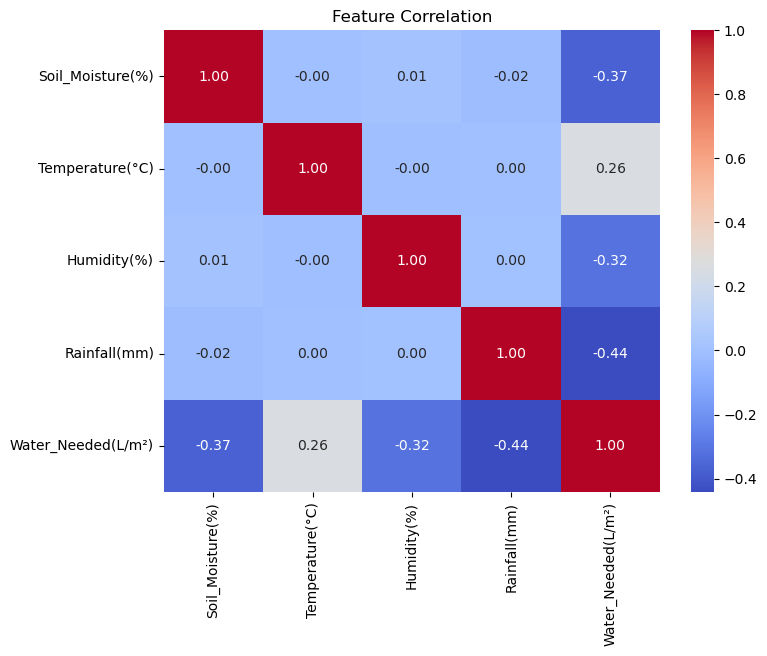

In [4]:
# Correlation heatmap
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

## Preprocessing

We'll one-hot encode `Crop_Type` and scale numerical features. Then split into train/test sets.

In [6]:
# Define features and target
TARGET = 'Water_Needed(L/m²)'
X = df.drop(columns=[TARGET])
y = df[TARGET]

cat_cols = ['Crop_Type']
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(sparse_output=False, drop='first'), cat_cols),
    ('scale', StandardScaler(), num_cols)
], remainder='drop')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (24000, 5) Test shape: (6000, 5)


## Modeling

Train a RandomForest and a GradientBoosting model and compare performance.

In [8]:
# Pipelines
rf_pipe = Pipeline([('pre', preprocessor), ('rf', RandomForestRegressor(n_estimators=100, max_depth=20, random_state=RANDOM_STATE, n_jobs=-1))])
gbr_pipe = Pipeline([('pre', preprocessor), ('gbr', GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=RANDOM_STATE))])

# Train
print('Training RandomForest...')
rf_pipe.fit(X_train, y_train)
print('Training GradientBoosting...')
gbr_pipe.fit(X_train, y_train)

# Evaluate
def evaluate(model, X, y):
    preds = model.predict(X)
    try:
        rmse = mean_squared_error(y, preds, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y, preds))
    #rmse = mean_squared_error(y, preds, squared=False)
    r2 = r2_score(y, preds)
    return rmse, r2, preds

rmse_rf, r2_rf, preds_rf = evaluate(rf_pipe, X_test, y_test)
rmse_gbr, r2_gbr, preds_gbr = evaluate(gbr_pipe, X_test, y_test)

print(f'RandomForest RMSE: {rmse_rf:.3f}, R2: {r2_rf:.3f}')
print(f'GradientBoosting RMSE: {rmse_gbr:.3f}, R2: {r2_gbr:.3f}')

Training RandomForest...
Training GradientBoosting...
RandomForest RMSE: 3.278, R2: 0.968
GradientBoosting RMSE: 3.142, R2: 0.970


## Feature Importances

Extract feature names from the preprocessor and plot importances from the selected model.

,feature,importance
0,Crop_Type_Rice,0.369225
6,Rainfall(mm),0.210154
3,Soil_Moisture(%),0.147231
5,Humidity(%),0.102000
2,Crop_Type_Wheat,0.089714
4,Temperature(°C),0.070709
1,Crop_Type_Soybean,0.010969


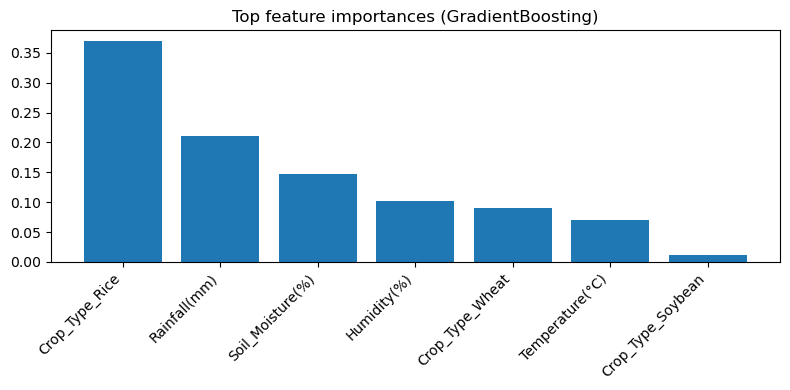

In [9]:
# Choose best model
if rmse_rf <= rmse_gbr:
    final_model = rf_pipe
    model_name = 'RandomForest'
    final_preds = preds_rf
else:
    final_model = gbr_pipe
    model_name = 'GradientBoosting'
    final_preds = preds_gbr

# Fit preprocessor on training data to extract feature names
preprocessor.fit(X_train)
ohe = preprocessor.named_transformers_['ohe']
ohe_names = list(ohe.get_feature_names_out(['Crop_Type']))
feature_names = ohe_names + num_cols

# Extract importances if available
model_obj = final_model.named_steps[list(final_model.named_steps.keys())[-1]]
if hasattr(model_obj, 'feature_importances_'):
    importances = model_obj.feature_importances_
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
    display(fi.head(10))
    plt.figure(figsize=(8,4))
    plt.bar(fi['feature'][:8], fi['importance'][:8])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top feature importances ({model_name})')
    plt.tight_layout()
    plt.show()
else:
    print('Model does not expose feature_importances_')

## Sample Predictions

Show a few rows of features with actual vs predicted water need.

In [10]:
pred_df = X_test.reset_index(drop=True).copy()
pred_df['Actual_Water'] = y_test.reset_index(drop=True)
pred_df['Predicted_Water'] = np.round(final_preds, 2)
pred_df.head(10)

,Soil_Moisture(%),Temperature(°C),Humidity(%),Rainfall(mm),Crop_Type,Actual_Water,Predicted_Water
0,15.691920,24.629008,40.850999,109.170692,Wheat,20.71,17.32
1,25.058277,25.858663,57.282584,119.307187,Wheat,6.26,7.54
2,30.662550,25.097232,52.035820,15.476188,Wheat,26.73,27.28
3,35.633072,27.356490,32.924522,36.047999,Rice,61.26,62.66
4,40.387606,29.823077,68.848073,27.481212,Soybean,29.37,28.45
5,42.583990,22.880906,73.223926,123.294017,Soybean,0.00,2.41
6,41.175266,23.511014,82.167409,82.428911,Wheat,0.00,0.38
7,37.446626,33.308489,48.787701,125.932365,Soybean,17.78,17.96
8,35.443813,16.426460,42.171997,3.851120,Soybean,30.19,32.12
9,35.519781,32.745091,75.248036,141.645696,Soybean,6.86,7.85


## SHAP Explainability

SHAP helps explain model predictions. If `shap` is not installed in your environment, run `pip install shap` in a notebook cell first. SHAP can be resource intensive on large datasets — we'll sample a subset for speed.

   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   ---------------------------------------- 547.8/547.8 kB 3.5 MB/s  0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
100%|===================| 1992/2000 [00:12<00:00]        

SHAP summary plot (be patient — may take a moment)


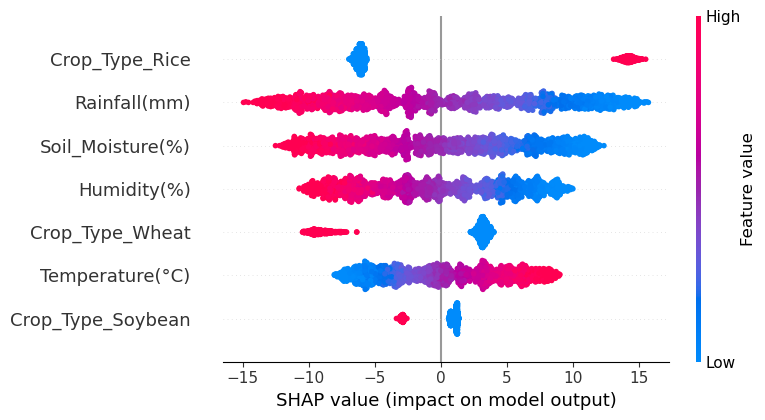

In [12]:
# SHAP analysis (may require installing the package)
# If shap is not installed, uncomment the pip line below and run this cell:
!pip install shap

import shap

# Use a small sample for SHAP to keep compute reasonable
sample_X = X_train.sample(n=2000, random_state=RANDOM_STATE).reset_index(drop=True)

# Preprocess sample to get model-ready matrix
pre = preprocessor.transform(sample_X)
# If final_model is a pipeline, extract underlying fitted model
model_obj = final_model.named_steps[list(final_model.named_steps.keys())[-1]]

explainer = shap.Explainer(model_obj, pre, feature_names=feature_names)
shap_values = explainer(pre)

# Summary plot
print('SHAP summary plot (be patient — may take a moment)')
shap.summary_plot(shap_values, pre, feature_names=feature_names, show=True)

## Save final model and predictions

Save the trained model and test predictions for later use.

In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_regression_metrics(y_true, y_pred):
    # --- Model Evaluation Metrics ---

    # R² → how much variance your model explains (closer to 1 is better).
    r2 = r2_score(y_true, y_pred)

    # RMSE → average prediction error magnitude (lower is better).
    rmse = mean_squared_error(y_true, y_pred) ** 0.5

    # MAE → average absolute error (lower is better).
    mae = mean_absolute_error(y_true, y_pred)

    # --- Safe MAPE Calculation ---
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # only consider non-zero targets
    if np.sum(mask) == 0:
        mape = np.nan
        approx_accuracy = np.nan
    else:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        approx_accuracy = max(0, 100 - mape)  # higher is better

    # Print results nicely
    print("Model Performance Metrics:")
    print(f"R² Score:        {r2:.3f}")
    print(f"RMSE:            {rmse:.3f}")
    print(f"MAE:             {mae:.3f}")
    if not np.isnan(mape):
        print(f"MAPE:            {mape:.2f}%")
        print(f"Approx Accuracy: {approx_accuracy:.2f}%")
    else:
        print("MAPE:            Not applicable (contains zero targets)")

    return {
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "Approx Accuracy (%)": approx_accuracy
    }

metrics = evaluate_regression_metrics(y_test, final_preds)

Model Performance Metrics:
R² Score:        0.970
RMSE:            3.142
MAE:             2.517
MAPE:            25.07%
Approx Accuracy: 74.93%


In [ ]:
# Save final model
model_path = os.path.join(OUTPUT_DIR, f'smart_irrigation_{model_name.lower()}.pkl')
joblib.dump(final_model, model_path)
print('Saved model to', model_path)

# Save predictions CSV
predictions_csv = os.path.join(OUTPUT_DIR, 'test_predictions.csv')
pred_df.to_csv(predictions_csv, index=False)
print('Saved predictions to', predictions_csv)

## Conclusion

- This notebook shows a complete pipeline for predicting water needs.
- For production-ready deployment consider: more careful hyperparameter tuning, cross-validation, calibration, handling seasonality, and using time-series models if your data is temporal.

If you want, I can:
- Add cross-validation and hyperparameter tuning cells
- Replace GradientBoosting with LightGBM/XGBoost
- Add a dashboard (Streamlit) for live predictions

Tell me which you'd like next.